(2000, 1155)


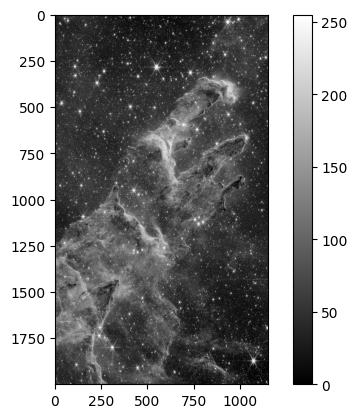

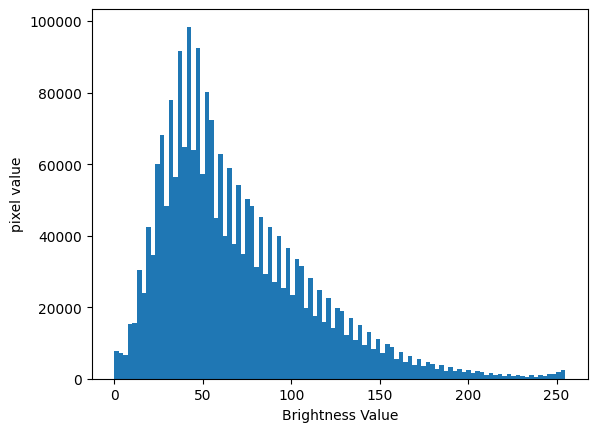

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Open the tiff file called "great pillars of creation" and read the image data
from PIL import Image
# im = Image.open('great pillars of creation.tif')
im = Image.open('gpoc.png')
image_data = np.array(im.convert('L'))
print(image_data.shape)


# Plot the image data
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.show()

# Show the distribution of brightness value in the image
# Label the axes
plt.xlabel('Brightness Value')
plt.ylabel('pixel value')
plt.hist(image_data.flat, bins=100, range=(0,255))
plt.show()

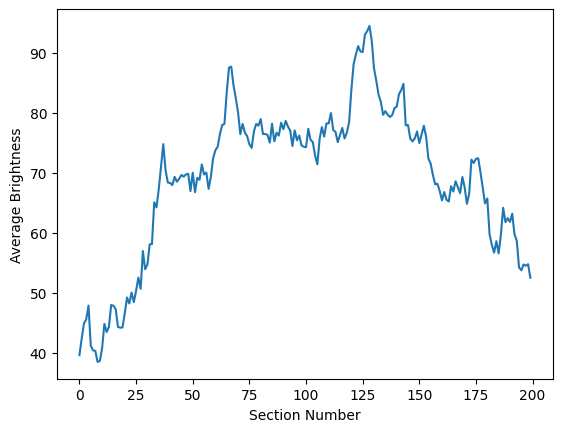

In [75]:
# Split the image top down into 20 sections, each with width 100 pixels. 
# Calculate the average brightness of each section and plot the results.
# Also print the each section of the
# This is a way to reduce the noise in the image
# We will use the numpy function reshape to split the image into sections
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html
# Label the x and y axis of the plot
image_data_reshaped = image_data.reshape(-1, 10, 1155)
image_data_reshaped_mean = np.mean(image_data_reshaped, axis=(1,2))
n = len(image_data_reshaped_mean)
plt.plot(image_data_reshaped_mean)
plt.xlabel('Section Number')
plt.ylabel('Average Brightness')
plt.show()


In [76]:
# # Print the 60 splitted sections of the image (20 rows, 3 columns)
# for i in image_data_reshaped:
#     plt.imshow(i, cmap='gray')
#     plt.show()

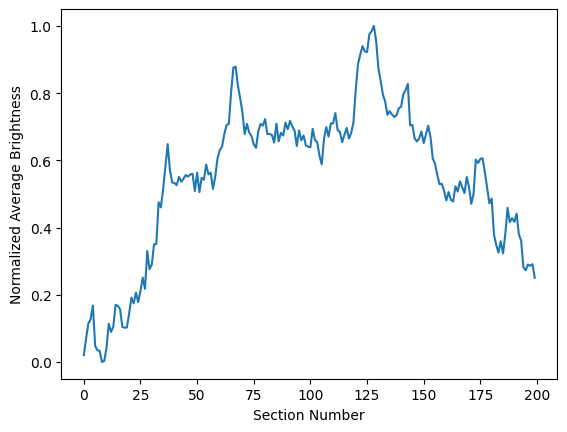

In [77]:
# Normalize the mean brightness of each section to the range 0 to 1

# Plot the normalized brightness of each section
# Label the x and y axis of the plot
def map_value(value, min_value, max_value, min_result, max_result):
    '''maps value (or array of values) from one range to another'''
    
    result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
    return result

image_data_reshaped_mean_norm = map_value(image_data_reshaped_mean, np.min(image_data_reshaped_mean), np.max(image_data_reshaped_mean), 0, 1)
plt.plot(image_data_reshaped_mean_norm)
plt.xlabel('Section Number')
plt.ylabel('Normalized Average Brightness')
plt.show()



In [78]:
# Extract the brightest section of the image from image_data_reshaped
gray_img = im.convert('L')
b_max, b_min = 250, 150
print(b_max, b_min)
desired_pixels = [(x, y) for x in range(gray_img.width) for y in range(gray_img.height)
                  if b_min <= gray_img.getpixel((x, y)) <= b_max]

# print(desired_pixels)


250 150


In [79]:
myrs_per_beat = 40  #number of pixel for each beat of music 

time = image_data_reshaped_mean #time 
t_data = time/myrs_per_beat #rescale time from Myrs to beats


duration_beats = 40 #desired duration in beats (actually, onset of last note)

t_data = map_value(time, 0, np.max(time), 0, duration_beats)

#or
#t_data = map_value(ages, min(ages), max(ages), duration_beats, 0)

myrs_per_beat = np.max(time)/duration_beats
print('pixels per beat:', myrs_per_beat)

#calculate duration in seconds
bpm = 60  #if bpm = 60, 1 beat = 1 sec 
duration_sec = duration_beats*60/bpm #duration in seconds (actually, onset of last note)
print('Duration:', duration_sec, 'seconds')

pixels per beat: 2.361865800865801
Duration: 40.0 seconds


In [80]:
from audiolazy import str2midi

#custom note set (a voicing of a Cmaj13#11 chord, notes from C lydian)
note_names = ['C1','C2','G2',
             'C3','E3','G3','A3','B3',
             'D4','E4','G4','A4','B4',
             'D5','E5','G5','A5','B5',
             'D6','E6','F#6','G6','A6']

note_midis = [str2midi(n) for n in note_names]
n_notes = len(note_midis)
print('Resolution:',n_notes, 'notes')

Resolution: 23 notes


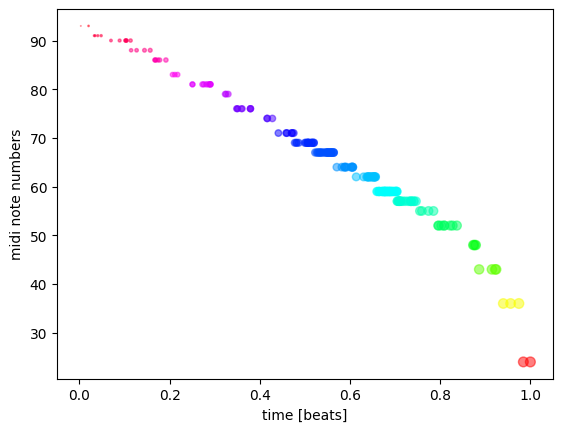

In [81]:
midi_data = []
for i in range(n):
    note_index = round(map_value(image_data_reshaped_mean_norm[i], 0, 1, n_notes-1, 0)) #notice choice of polarity: bigger craters are mapped to lower notes
                                                        #we round the result because it's a list index which must be an integer
    midi_data.append(note_midis[note_index])

plt.scatter(image_data_reshaped_mean_norm, midi_data, s=50*image_data_reshaped_mean_norm, alpha=0.5, c=midi_data, cmap='hsv')
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()

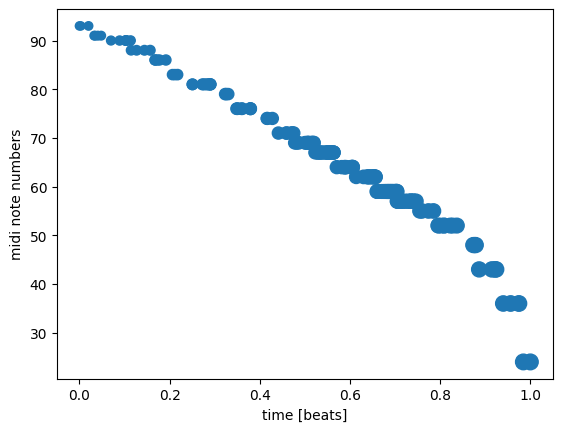

In [82]:
vel_min,vel_max = 35,127   #minimum and maximum note velocity

vel_data = []
for i in range(n):
    note_velocity = round(map_value(image_data_reshaped_mean_norm[i], 0, 1, vel_min, vel_max)) #bigger craters will be louder
                                                                #we round here because note velocites are integers
    vel_data.append(note_velocity)
    
plt.scatter(image_data_reshaped_mean_norm, midi_data, s=vel_data)
plt.xlabel('time [beats]')
plt.ylabel('midi note numbers')
plt.show()

In [83]:
from midiutil import MIDIFile #import library to make midi file, https://midiutil.readthedocs.io/en/1.2.1/
    
#create midi file object, add tempo
my_midi_file = MIDIFile(1) #one track 
my_midi_file.addTempo(track=0, time=0, tempo=40) 

#add midi notes
for i in range(n):
    my_midi_file.addNote(track=0, channel=0, pitch=midi_data[i], time=t_data[i], duration=2, volume=vel_data[i])

#create and save the midi file itself
with open('str1' + '.mid', "wb") as f:
    my_midi_file.writeFile(f) 

PermissionError: [Errno 13] Permission denied: 'str1.mid'